In [2]:
pip install keras

     ---------------------------------------- 0.0/50.1 kB ? eta -:--:--
     --------------- ---------------------- 20.5/50.1 kB 640.0 kB/s eta 0:00:01
     ------------------------------- ------ 41.0/50.1 kB 653.6 kB/s eta 0:00:01
     -------------------------------------- 50.1/50.1 kB 504.2 kB/s eta 0:00:00
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ------ --------------------------------- 0.2/1.3 MB 6.3 MB/s eta 0:00:01
   ----------- ---------------------------- 0.4/1.3 MB 4.9 MB/s eta 0:00:01
   ------------------------- -------------- 0.8/1.3 MB 5.9 MB/s eta 0:00:01
   ------------------------------------- -- 1.3/1.3 MB 7.4 MB/s eta 0:00:01
   ---------------------------------------- 1.3/1.3 MB 6.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/133.7 kB ? eta -:--:--
   ---------------------------------------- 133.7/133.7 kB 8.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/210.9 kB ? eta -:--:--
   --------------

In [3]:
pip install numpy 

Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install tensorflow

  Using cached tensorflow-2.18.0-cp312-cp312-win_amd64.whl.metadata (3.3 kB)
  Using cached tensorflow_intel-2.18.0-cp312-cp312-win_amd64.whl.metadata (4.9 kB)
Using cached tensorflow-2.18.0-cp312-cp312-win_amd64.whl (7.5 kB)
Using cached tensorflow_intel-2.18.0-cp312-cp312-win_amd64.whl (390.3 MB)
Note: you may need to restart the kernel to use updated packages.


Matplotlib is building the font cache; this may take a moment.
C:\Users\shrey\AppData\Local\Temp\ipykernel_19844\1651922939.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_dataset["Date"][i]=data['Date'][i]
C:\Users\shrey\AppData\Local\Temp\ipykernel_19844\1651922939.py:30: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.lo

927/927 - 43s - 46ms/step - loss: 9.6486e-04
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step


C:\Users\shrey\AppData\Local\Temp\ipykernel_19844\1651922939.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=closing_price


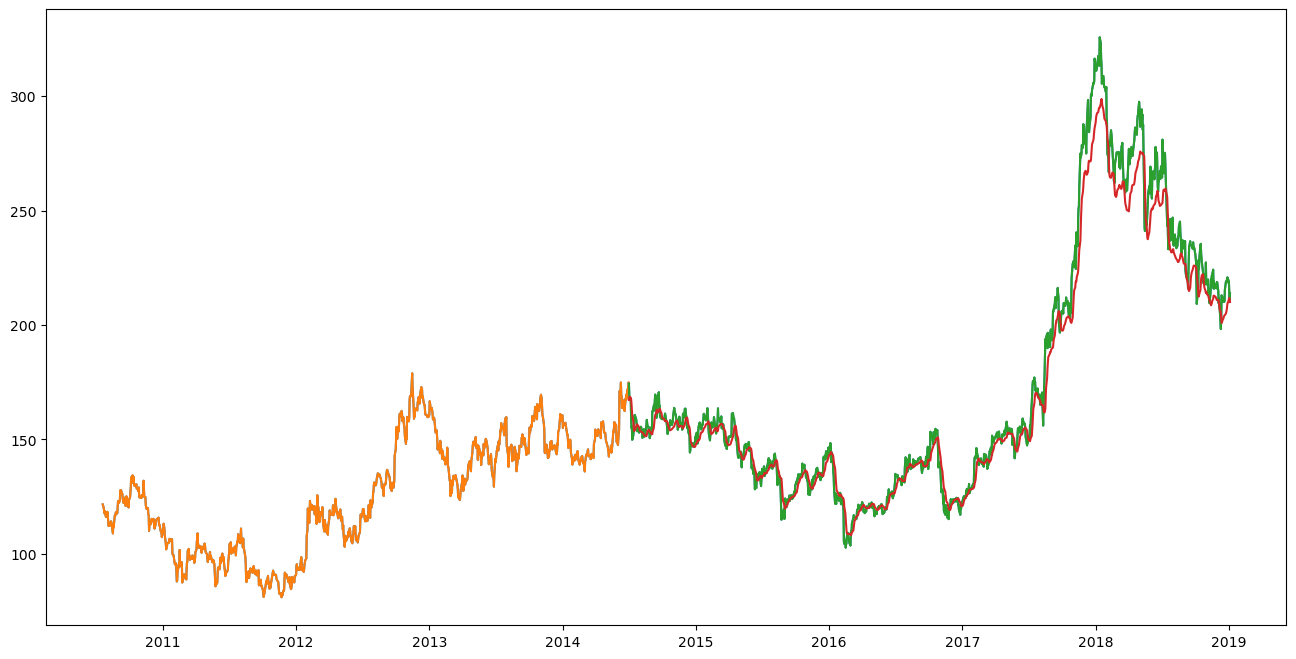

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt


from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))

df=pd.read_csv("NSE-TATAGLOBAL.csv")
df.head()

df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']

plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dropout,Dense

data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]
    

new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

final_dataset=new_dataset.values

train_data=final_dataset[0:987,:]
valid_data=final_dataset[987:,:]

scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))




lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)


X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
closing_price=lstm_model.predict(X_test)
closing_price=scaler.inverse_transform(closing_price)

lstm_model.save("saved_model.h5")

train_data=new_dataset[:987]
valid_data=new_dataset[987:]
valid_data['Predictions']=closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])